# 导入包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# 定义函数

In [2]:
def showfig(X, y):
    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.show()

def distance(x1, x2, mode='Euclidean'):
    if mode == 'Manhattan':
        return np.sum(np.abs(x1 - x2))
    elif mode == 'Euclidean':
        return np.sqrt(np.sum((x1 - x2)**2))
    elif mode == 'Cosine':
        return x1.dot(x2) / (np.linalg.norm(x1)*np.linalg.norm(x2))

# 定义类

In [3]:
class KMeans():
    """
    Attributes:
        n_clusters: {int} 划分簇的个数
        mode: {str} 距离衡量指标, 'Manhattan', 'Euclidean' or 'Cosine'
        centroids: {ndarray(n_clusters, n_features)}
    Notes:
        K-means对初始敏感 
            - 运行多次
            - 每次随机初始化中心点
            - 选择
    """
    def __init__(self, n_clusters, mode):
        self.n_clusters = n_clusters
        self.mode = mode
        self.centroids = None
    def fit(self, X, max_iter=5, min_move=0.1, display=False):
        """
        Args:
            X: {ndarray(n_samples, n_features)}
            max_iter: {int} 最大迭代次数
            min_move: {float} 终止条件的阈值
            display: {bool} 若为`True`，则显示程序运行过程
        """
        n_samples = X.shape[0]
        n_features = X.shape[1]
        def initializeCentroids():
            ''' 
            Return:
                centroids: {ndarray(n_clusters, n_features)}
            '''
            centroids = np.zeros(shape=(self.n_clusters, n_features))
            pointIdx = []                                       # indexes of chosen centroids
            for n in range(self.n_clusters):
                idx = np.random.randint(0, n_samples)           # choose a centroid randomly
                while idx in pointIdx:                          # if already choosen, choose again
                    idx = np.random.randint(0, n_samples)
                pointIdx.append(idx)
                centroids[n] = X[idx]
            return centroids
        def dist2Centroids(x, centroids, mode):
            ''' 返回 x 到 centroids 的距离
            Args:
                x: {ndarray(n_features,)} 某样本
                mode: {str} 距离度量指标
            Return:
                d: {ndarray(n_clusters,)} 距离
            '''
            d = np.zeros(shape=(self.n_clusters,))
            for n in range(self.n_clusters):
                d[n] = distance(x, centroids[n], mode)
            return d
        def nearestInfo(centroids, mode):
            ''' 每个样本最近中心点的相关信息
            Args:
                centroids: 
                mode: {str} 距离度量指标
            Return:
                ctIdx: {ndarray(n_samples,)} 个样本最近中心的索引
                ctDist: {ndarray(n_samples,)} 各样本到最近中心点的距离
            '''
            ctIdx = -np.ones(shape=(n_samples,), dtype=np.int8)    
            ctDist = np.ones(shape=(n_samples,), dtype=np.float)
            for i in range(n_samples):
                dists = dist2Centroids(X[i], centroids, mode)
                if mode == 'Euclidean': ctIdx[i] = np.argmin(dists)
                elif mode == 'Cosine':  ctIdx[i] = np.argmax(dists)
                ctDist[i] = dists[ctIdx[i]]
            return ctIdx, ctDist
        def updateCentroids(ctIdx):
            '''
            Args:
                ctIdx: {ndarray(n_samples,)} 最近点的索引
            Return:
                centroids: {ndarray(n_clusters, n_features)} 更新后的中心点
            '''
            centroids = np.zeros(shape=(self.n_clusters, n_features))
            for n in range(self.n_clusters):
                X_ = X[ctIdx == n]
                centroids[n] = np.mean(X_, axis=0)
            return centroids
        def loss(dist):
            return np.mean(dist**2)
        # -----------------------------------------
        loss_min = float('inf')                         # 初始化损失
        plt.ion()
        for n_iter in range(max_iter):
            isDone = False	                            # 若np.abs(loss_last - loss_now) < min_move，则置位
            centroids_tmp = initializeCentroids()       # 随机初始化
            loss_last = float('inf')
            n_update = 0                                # 用于计数
            while not isDone:
                n_update += 1
                ctIdx, ctDist = nearestInfo(centroids_tmp, mode=self.mode)
                centroids_tmp = updateCentroids(ctIdx)
                # --- visualization ---
                if (display==True) and (n_features == 2):
                    plt.ion()
                    plt.figure(n_iter); plt.cla()
                    plt.scatter(X[:, 0], X[:, 1], c=ctIdx)
                    plt.scatter(centroids_tmp[:, 0], centroids_tmp[:, 1], c='r')
                    plt.pause(0.5)
                # --------------------
                loss_now = loss(ctDist)
                if np.abs(loss_last - loss_now) < min_move:
                    isDone = True
                else: loss_last = loss_now
            if loss_now < loss_min:
                self.centroids = centroids_tmp          # 选择最佳的结果
                loss_min = loss_now
        plt.ioff()

    def predict(self, X):
        '''
        Args: 
            X: {ndarray(n_samples, n_features)}
        Return:
            labels: {ndarray(n_samples,)}
        '''
        n_samples = X.shape[0]
        labels = -np.ones(shape=(n_samples,), dtype=np.int)
        for i in range(n_samples):
            dists_i = np.zeros(shape=(self.n_clusters,))
            for n in range(self.n_clusters):
                dists_i[n] = distance(X[i], self.centroids[n], mode=self.mode)
            if self.mode == 'Euclidean':
                labels[i] = np.argmin(dists_i)
            elif self.mode == 'Cosine':
                labels[i] = np.argmax(dists_i)
        return labels

# 生成数据集并显示

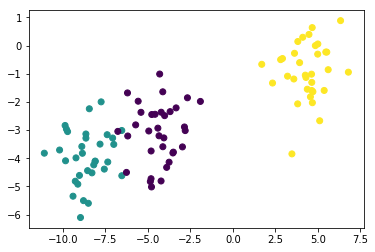

In [4]:
X, y = make_blobs()
showfig(X, y)

# 训练并预测，显示

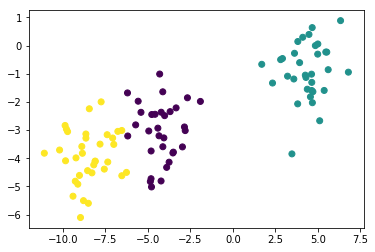

In [5]:
estimator = KMeans(n_clusters=3, mode = 'Euclidean')
estimator.fit(X)
y_pred = estimator.predict(X)
showfig(X, y_pred)